# Regression analysis - Sharechat annotated claims dataset

Research - https://arxiv.org/abs/2010.13387

### Steps

1. Loading and combining annotated data files
2. Engineering new features using Optical Character Recognition, Named Entity Recognition etc
3. Train test split 
4. Missing value imputation
5. Standardizing numeric variables
6. Dummifying categorical variables
7. Building and evaluating a logistic regression model
8. Plotting learning curves and comparing with other models

In [801]:
import sys
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import os
import numpy as np
import re
import string
from pprint import pprint
import json
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import random
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
import requests
import logging
from datetime import datetime, timedelta
import time
import spacy
nlp = spacy.load("en_core_web_sm")
from googletrans import Translator
import time
from time import perf_counter
from random import uniform
import emoji
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
pd.options.mode.chained_assignment = None
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import to_graphviz
from sklearn.tree import export_graphviz
import scipy
from google.cloud import translate_v2 as translate
import wget
from google.cloud import vision
from google.protobuf.json_format import MessageToJson
import requests
from PIL import Image
import io
from io import BytesIO

## Load data

In [802]:
ind = pd.read_csv(os.environ.get("ANNOTATION_IND"))
group1 = pd.read_csv(os.environ.get("ANNOTATION_GRP1"))
group2 = pd.read_csv(os.environ.get("ANNOTATION_GRP2"))

In [803]:
df = ind.append(group1).append(group2)

In [804]:
df.reset_index(drop=True, inplace=True)

In [805]:
df.to_csv("sharechat_annotated_zenodo.csv")

In [806]:
def claims(data):
    if "Yes" in str(data):
        return 1
    else:
        return 0

In [807]:
df["claim"] = df["verifiable_claim"].map(claims)

In [808]:
# Drop columns that won't be required
df.drop(["annotator_label", "_id", "verifiable_claim"], axis=1, inplace=True)

In [810]:
# Drop columns with low inter-annotator agreement
df.drop(["visible_source"], axis=1, inplace=True)

## Feature Engineering

1. Number of hashtags
2. Hour of day bins
3. Number of words in text / extracted text
4. Named entities in text (whether present or not)

In [811]:
def count_hashtags(data):
    return len(re.findall("#", str(data)))

In [812]:
df["n_hashtags"] = df["caption"].map(count_hashtags)

In [813]:
df["datetime"] = pd.to_datetime(df["timestamp"])

In [814]:
def hour(data):
    time = data.time()
    hour_string = str(time)[:2]
    hour_int = int(hour_string) 
    return hour_int

In [815]:
df["hour"] = df["datetime"].map(hour)

In [816]:
images_df=df[df["media_type"]=="image"]
print(len(images_df))

1372


In [817]:
images_df["s3_url"] = "https://s3.ap-south-1.amazonaws.com/sharechat-scraper.tattle.co.in/" + images_df["filename"] + ".jpg"

In [818]:
# %%time
# for i in images_df["s3_url"]:
#     wget.download(i, out="images/")

In [819]:
# %%time
# f=0
# extractions = {}
# texts = []
# client = vision.ImageAnnotatorClient()
# img_folder = os.getcwd() + "/images"
# for i in os.listdir(img_folder):
#     if i != '.DS_Store':
#         path = os.getcwd() + "/images/" + i
#         with io.open(path, 'rb') as image_file:
#             content = image_file.read()
#         image = vision.Image(content=content)
#         try:
#             resp = client.text_detection(image=image)
#             text = resp.full_text_annotation.text
#             extractions[i] = text
#             texts.append(text)
#         except Exception:
#             f+=1
#             extractions[i] = ''
#             texts.append("")

In [820]:
# with open("extractions.json","w") as f:
#     json.dump(extractions, f)

In [821]:
# Load previously extracted image text
with open("extractions.json","r") as f:
    extractions = json.loads(f.read())

In [822]:
def match_texts(filename):
    text = extractions.get(filename+".jpg")
    return text

In [823]:
# Extract text from images
df["extracted_text"] = df["filename"].map(match_texts)

In [824]:
def remove_newlines(data):
    if data != None:
        return re.sub("\n", " ", data)
    else:
        return None

In [825]:
df["extracted_text"] = df["extracted_text"].map(remove_newlines)

In [826]:
# Replace nans and Nones with blank strings
df["extracted_text"] = np.where(df["extracted_text"]!=df["extracted_text"], "", df["extracted_text"])
df["text"] = np.where(df["text"]!=df["text"], "", df["text"])

In [827]:
df["combined_text"] = df["extracted_text"] + df["text"]

In [828]:
def count_words(data):
    if data == data:
        wordlist = data.split(" ")
        if len(data) > 0:
            return(len(wordlist))
        else:
            return 0
    else:
        return 0

In [829]:
df["n_words"] = df["combined_text"].map(count_words)

In [830]:
# Fix bad label
df["contains_image"] = np.where(df["contains_image"] == "Does no contain human(s)", "Does not contain human(s)", df["contains_image"])

In [831]:
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)

In [832]:
df["combined_text"] = df["combined_text"].map(remove_emoji)

In [833]:
translator = translate.Client()

In [834]:
def translate_text(text):
    text = translate_client.translate(text).get("translatedText", "")
    return text

In [835]:
# start = perf_counter()
# df["translation"] = df["combined_text"].map(translate_text)
# delta = perf_counter() - start
# print(delta)

339.2452673840162


In [836]:
# df.to_csv("sharechat_annotated_translated.csv", index=False)

In [838]:
df = pd.read_csv("sharechat_annotated_translated.csv", index_col=None)

In [842]:
df["translation"] = np.where(df["translation"]!=df["translation"], "", df["translation"])

In [843]:
def get_entities(text):
    entities = []
    doc = nlp(text)
    for ent in doc.ents:
#         if ent.label_ in ["PERSON", "NORP", "ORG", "GPE"]:
        entities.append(ent.text)
    return entities

In [845]:
df["named_entities"] = df["translation"].map(get_entities)

In [846]:
df["entities_count"] = df["named_entities"].map(len)

In [852]:
# Drop columns that won't be required
drop_cols = [
        "tag_name", "tag_translation", "timestamp", 
        "caption", "text", "filename",
        "datetime", "extracted_text", "named_entities", "combined_text"]

## Preprocessing

In [908]:
# Train test split
X = df.drop("claim", axis=1)
y = df["claim"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [909]:
def prepare_data(df):
    # Drop columns that won't be used 
    df.drop(drop_cols, axis=1, inplace=True)
    return df

In [910]:
X_train = prepare_data(X_train)

In [911]:
# Count missing values in each column
X_train.isna().sum()

bucket_name                0
external_shares            0
likes                      0
media_type                 0
contains_video            29
contains_image            28
contains_relevant_meme    28
n_hashtags                 0
hour                       0
n_words                    0
translation                0
entities_count             0
dtype: int64

In [912]:
# Impute nans in categorical columns
imputer = SimpleImputer(strategy="most_frequent")

In [913]:
columns = X_train.columns
X_train = pd.DataFrame(imputer.fit_transform(X_train))
X_train.columns = columns

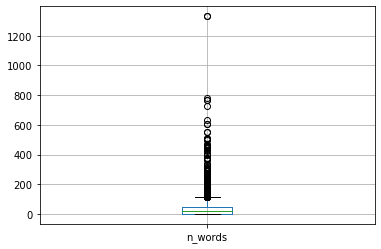

In [914]:
# Inspect numeric variables for outliers
df.boxplot(column="n_words")

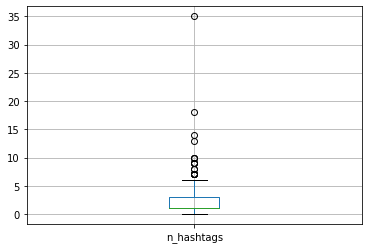

In [915]:
df.boxplot(column="n_hashtags")

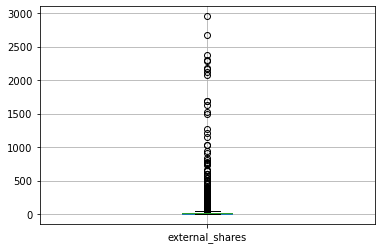

In [916]:
df.boxplot(column="external_shares")

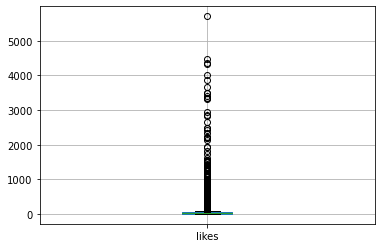

In [917]:
df.boxplot(column="likes")

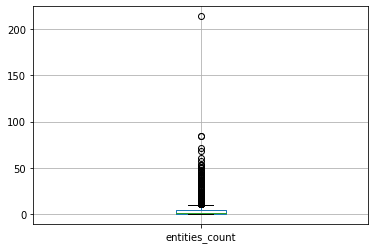

In [918]:
df.boxplot(column="entities_count")

In [919]:
# Standardize numeric variables
scaler = StandardScaler()
num = ["n_words", "n_hashtags", "likes", "external_shares", "entities_count"]
num_cols = pd.DataFrame(scaler.fit_transform(X_train[num]))
num_cols.columns = num

In [920]:
# Convert categorical columns
cat = [
    "media_type", "contains_video", "contains_image", 
    "contains_relevant_meme", "bucket_name", "hour"]
X_train[cat] = X_train[cat].apply(pd.Categorical)

In [921]:
# Dummify categorical columns
cat_cols = pd.get_dummies(X_train[cat], drop_first = True)

In [922]:
X_train = pd.concat([cat_cols, num_cols], axis=1)

In [923]:
# Encode target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

In [924]:
# Apply preprocessing to test set
X_test = prepare_data(X_test)

columns = X_test.columns
X_test = pd.DataFrame(imputer.transform(X_test))
X_test.columns = columns

num_cols = pd.DataFrame(scaler.transform(X_test[num]))
num_cols.columns = num

X_test[cat] = X_test[cat].apply(pd.Categorical)

cat_cols = pd.get_dummies(X_test[cat], drop_first = True)
X_test = pd.concat([cat_cols, num_cols], axis=1)

y_test = label_encoder.transform(y_test)

In [925]:
# Defining a function to fix column difference between train and test sets

# This will go inside the main function
def add_missing_dummy_columns(test_set, train_columns):
    # d = test set, columns = train set columns 
    missing_cols = set(train_columns) - set(test_set.columns)
    for c in missing_cols:
        test_set[c] = 0 # add missing columns to test set with empty column values
        
# This is the main function     
def fix_columns(test_set, train_columns):  

    add_missing_dummy_columns(test_set, train_columns)

    # make sure we have all the columns we need
    assert(set(train_columns) - set(test_set.columns) == set())

    extra_cols = set(test_set.columns) - set(train_columns) # these are the extra cols in the test set
    if extra_cols:
        print ("extra columns:", extra_cols)

    test_set = test_set[train_columns] # keep only columns that are in the train set 
    return test_set


In [926]:
X_test = fix_columns(X_test, X_train.columns)

extra columns: {'bucket_name_राजनीति '}


In [927]:
# Sanity check
assert(set(X_train.columns) - set(X_test.columns) == set())

In [929]:
vifs = pd.Series(np.linalg.inv(X_train.corr().values).diagonal(), index=X_train.corr().index)

In [930]:
vifs

media_type_text                                        1.229869
media_type_video                                       2.485142
contains_video_Other                                   1.504485
contains_video_Yes, contains violent incident          1.119002
contains_video_Yes, person is performing for camera    1.910311
contains_image_Does not contain human(s)               1.204865
contains_image_No, does not contain images             1.349313
contains_relevant_meme_Yes                             1.241724
bucket_name_ख़बरें                                     1.076952
bucket_name_ख़बरें और राजनीति                          2.358626
bucket_name_देश प्रेम                                  2.246841
bucket_name_फिल्मी दुनिया                              1.021826
bucket_name_लॉकडाउन                                    1.044512
bucket_name_शेयरचैट trends                             1.084896
bucket_name_स्वास्थ्य                                  2.476996
hour_1                                  

In [931]:
# Drop columns with high VIFs
vif_cols = ["hour_4", "hour_5", "hour_6", "hour_8", "hour_9", "hour_10", "hour_12", "hour_14", "hour_15", "hour_16", "hour_17", "hour_18"]
X_train.drop(vif_cols, axis=1, inplace=True)
X_test.drop(vif_cols, axis=1, inplace=True)

## Model building

In [932]:
logit_model = sm.Logit(y_train, X_train, random_state=0)
result = logit_model.fit(maxiter=100)

Optimization terminated successfully.
         Current function value: 0.550029
         Iterations 24


In [934]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1760
Model:                          Logit   Df Residuals:                     1729
Method:                           MLE   Df Model:                           30
Date:                Thu, 26 Nov 2020   Pseudo R-squ.:                  0.1752
Time:                        13:53:53   Log-Likelihood:                -968.05
converged:                       True   LL-Null:                       -1173.6
Covariance Type:            nonrobust   LLR p-value:                 1.561e-68
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
media_type_text                                        -0.3668      0.223     -1.644      0.100      -0.804       0.071
media_ty

In [935]:
# Keep features with significant p-values
keep = [
    "media_type_video", "contains_video_Other", "contains_video_Yes, contains violent incident", "contains_video_Yes, person is performing for camera", 
    "contains_image_Does not contain human(s)", "contains_image_No, does not contain images", "contains_relevant_meme_Yes", "bucket_name_ख़बरें और राजनीति", 
    "bucket_name_ख़बरें", "bucket_name_देश प्रेम ", "bucket_name_स्वास्थ्य", "hour_3", "hour_19", "likes", "external_shares", "entities_count"
]

In [936]:
X_train = X_train[keep]
X_test = X_test[keep]

In [937]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.7170454545454545
0.6818181818181818


In [938]:
# Count true / false positives / negatives
tn, fp, fn, tp = confusion_matrix(y_train, pred_train).ravel()
print(tn, fp, fn, tp)

931 150 348 331


In [939]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
print(tn, fp, fn, tp)

211 48 92 89


In [940]:
# Calculate accuracy metrics
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      1081
           1       0.69      0.49      0.57       679

    accuracy                           0.72      1760
   macro avg       0.71      0.67      0.68      1760
weighted avg       0.71      0.72      0.70      1760



In [941]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       259
           1       0.65      0.49      0.56       181

    accuracy                           0.68       440
   macro avg       0.67      0.65      0.66       440
weighted avg       0.68      0.68      0.67       440



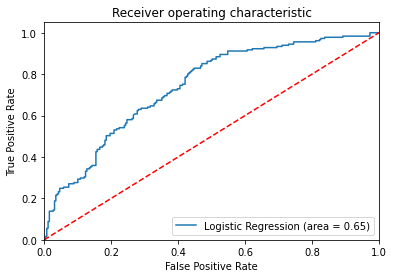

In [942]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Learning Curves & Model Comparisons

In [943]:
# Defining a function to plot a learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize = (10, 5))
    plt.title(title, fontsize = 14)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training samples", fontsize = 14)
    plt.ylabel("Accuracy", rotation = 90, fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(np.arange(.1, 1.0, 0.05), fontsize = 12)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid()
    return plt

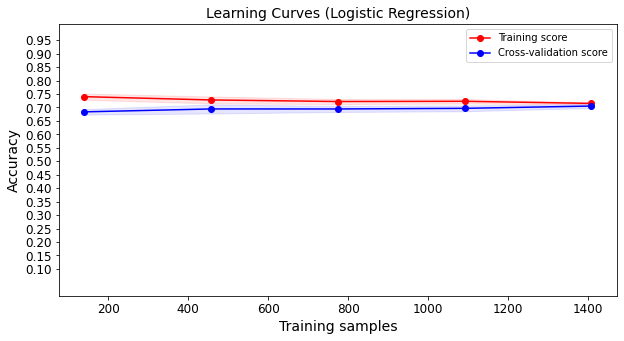

In [944]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = LogisticRegression(random_state=0)
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0, 1.01), cv=cv, n_jobs=1)
plt.show()

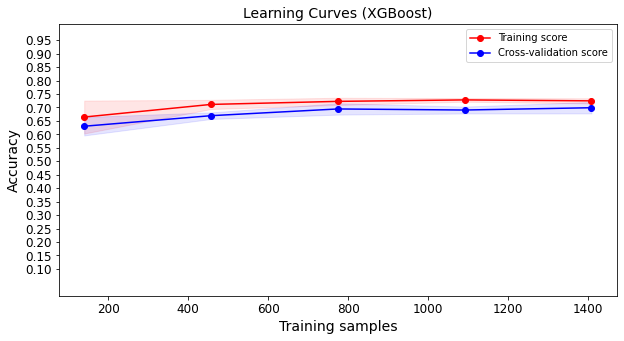

In [948]:
title = "Learning Curves (XGBoost)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = XGBClassifier(random_state=0, n_estimators=10, max_depth=3, gamma=10)
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0, 1.01), cv=cv, n_jobs=1)
plt.show()

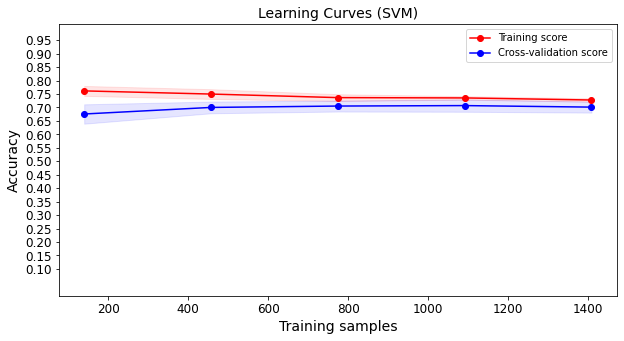

In [949]:
title = "Learning Curves (SVM)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = SVC(random_state=0, C=1)
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0, 1.01), cv=cv, n_jobs=1)
plt.show()